# Importing Libs

In [84]:
import pandas as pd
import numpy as np
import math
import sys
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from mpl_toolkits.axes_grid1 import AxesGrid

plt.style.use('ggplot')
path_project = "/home/igorcosta/PycharmProjects/football/"
sys.path.insert(1, path_project)
from core.config_loader import SysConfig

# Betting Strategies

In [85]:
countries_abv = {'Brazil A': 'BR1', 'Brazil B': 'BR2', 'England A': 'GB1', 'France A': 'FR1', 'Germany A': 'DE1', 'Italy A':'IT1', 'Netherlands A': 'NL1', 'Portugal A': 'PT1', 'Spain A': 'ES1' }
classifier_abv = {'XGBClassifier': 'XGB', 'GaussianNB': 'GNB', 'LogisticRegression': 'LRE', 'mkc': 'MKC', 'mcc':'MCC'}

def get_abv_list(countries):
    abv = list()
    for c in countries:
        abv.append(countries_abv[c])
        
    return abv

In [86]:
CLASSIFIERS = ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc', 'mcc']
CHAMPIONSHIPS =  ['Brazil A', 'Brazil B', 'England A', 'France A', 'Germany A', 'Italy A', 
                 'Netherlands A', 'Portugal A', 'Spain A']

exp1 = ['performance', 'gw']
exp2 = ['market','gw']
exp3 = ['total', 'gw']
EXPERIMENTS = [exp1, exp2, exp3]

CHAMPIONSHIP = 'm.ss.ch.nm'
RESULT = 'm.res.bts'
MODEL_PREDICTION = 'pred'
MARKET_PREDICTION = 'm.odds.f.bts.f.c'
MODEL_PROB_Y = 'pred_prob_y'
MODEL_PROB_N = 'pred_prob_n'

Y_ODD_MAX = 'm.odds.s.bts.y.o.max'
N_ODD_MAX = 'm.odds.s.bts.n.o.max'

Y_ODD_AVG = 'm.odds.s.bts.y.o.avg'
N_ODD_AVG = 'm.odds.s.bts.n.o.avg'

Y_PROB_AVG = 'm.odds.s.bts.y.t.avg'
N_PROB_AVG = 'm.odds.s.bts.n.t.avg'

BET_PR_BTS = 'bet.pred.res'
BET_PR_HIT = 'bet.pred.hit'
BET_PR_PL_AVG = 'bet.pred.pl.avg'
BET_PR_PL_MAX = 'bet.pred.pl.max'

BET_EV_BTS = 'bet.ev.res'
BET_EV_VAL_Y_AVG = 'bet.ev.val.y.avg'
BET_EV_VAL_N_AVG = 'bet.ev.val.n.avg'
BET_EV_VAL_Y_MAX = 'bet.ev.val.y.max'
BET_EV_VAL_N_MAX = 'bet.ev.val.n.max'

BET_EV_PL_Y_AVG = 'bet.ev.pl.y.avg'
BET_EV_PL_N_AVG = 'bet.ev.pl.n.avg'
BET_EV_PL_Y_MAX = 'bet.ev.pl.y.max'
BET_EV_PL_N_MAX = 'bet.ev.pl.n.max'

BET_EV_PL_AVG = 'bet.ev.pl.avg'
BET_EV_PL_MAX = 'bet.ev.res.max'

BET_KC_BTS = 'bet.kc.res'

BET_KC_VAL_Y_AVG = 'bet.kc.val.y.avg'
BET_KC_VAL_N_AVG = 'bet.kc.val.n.avg'
BET_KC_VAL_Y_MAX = 'bet.kc.val.y.max'
BET_KC_VAL_N_MAX = 'bet.kc.val.n.max'

BET_KC_PL_Y_AVG = 'bet.kc.pl.y.avg'
BET_KC_PL_N_AVG = 'bet.kc.pl.n.avg'
BET_KC_PL_Y_MAX = 'bet.kc.pl.y.max'
BET_KC_PL_N_MAX = 'bet.kc.pl.n.max'

BET_KC_PL_AVG = 'bet.kc.pl.avg'
BET_KC_PL_MAX = 'bet.kc.pl.max'

In [87]:
def bet_on_predicted(data):
    data[BET_PR_BTS] = data[MODEL_PREDICTION]
    data[BET_PR_HIT] = data[BET_PR_BTS] == data[RESULT]
    data[BET_PR_PL_AVG] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_AVG]-1, data[N_ODD_AVG]-1)), -1)
    
    data[BET_PR_PL_MAX] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_MAX]-1, data[N_ODD_MAX]-1)), -1)

def bet_with_expected_value(data):
    
    data[BET_EV_VAL_Y_AVG] = data[MODEL_PROB_Y]*data[Y_ODD_AVG]-1
    data[BET_EV_VAL_N_AVG] = data[MODEL_PROB_N]*data[N_ODD_AVG]-1
    data[BET_EV_VAL_Y_MAX] = data[MODEL_PROB_Y]*data[Y_ODD_MAX]-1
    data[BET_EV_VAL_N_MAX] = data[MODEL_PROB_N]*data[N_ODD_MAX]-1
    
    data[BET_EV_PL_Y_AVG] = np.where(data[BET_EV_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', data[Y_ODD_AVG]-1, -1))
                                    , 0)
    
    data[BET_EV_PL_N_AVG] = np.where(data[BET_EV_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', data[N_ODD_AVG]-1, -1))
                                    , 0)
        
    data[BET_EV_PL_Y_MAX] = np.where(data[BET_EV_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', data[Y_ODD_MAX]-1, -1))
                                     , 0)
        
    data[BET_EV_PL_N_MAX] = np.where(data[BET_EV_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', data[N_ODD_MAX]-1, -1))
                                     , 0)
    
    data[BET_EV_PL_AVG] = data[BET_EV_PL_Y_AVG] + data[BET_EV_PL_N_AVG]    
    data[BET_EV_PL_MAX] = data[BET_EV_PL_Y_MAX] + data[BET_EV_PL_N_MAX]

def bet_with_kelly_criterion(data):
    
    data[BET_KC_VAL_Y_AVG] = ((data[Y_ODD_AVG]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_AVG]-1)
    data[BET_KC_VAL_N_AVG] = ((data[N_ODD_AVG]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_AVG]-1)
    data[BET_KC_VAL_Y_MAX] = ((data[Y_ODD_MAX]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_MAX]-1)
    data[BET_KC_VAL_N_MAX] = ((data[N_ODD_MAX]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_MAX]-1)
    
        
    data[BET_KC_PL_Y_AVG] = np.where(data[BET_KC_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_AVG]*(data[Y_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_Y_AVG])), 0)
    data[BET_KC_PL_N_AVG] = np.where(data[BET_KC_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_AVG]*(data[N_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_N_AVG])), 0)
        
    data[BET_KC_PL_Y_MAX] = np.where(data[BET_KC_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_MAX]*(data[Y_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_Y_MAX])), 0)
        
    data[BET_KC_PL_N_MAX] = np.where(data[BET_KC_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_MAX]*(data[N_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_N_MAX])), 0)
        

    data[BET_KC_PL_AVG] = data[BET_KC_PL_Y_AVG] + data[BET_KC_PL_N_AVG]
    data[BET_KC_PL_MAX] = data[BET_KC_PL_Y_MAX] + data[BET_KC_PL_N_MAX]


In [88]:
def set_pl_pr(pl, data, row, col):

    vavg = data[BET_PR_PL_AVG].sum()
    vmax = data[BET_PR_PL_MAX].sum()
    
    pl.loc[row, '_'.join([col, 'AVG'])] = vavg
    pl.loc[row, '_'.join([col, 'MAX'])] = vmax
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = vavg/len(data)*100
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = vmax/len(data)*100
    
def set_pl_ev(pl, data, row, col):
       
    tavg = len(data[data[BET_EV_PL_AVG].abs() > 0])
    tmax = len(data[data[BET_EV_PL_MAX].abs() > 0])
       
    pl.loc[row, '_'.join([col, 'AVG'])] = data[BET_EV_PL_AVG].sum()
    pl.loc[row, '_'.join([col, 'MAX'])] = data[BET_EV_PL_MAX].sum()
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = data[BET_EV_PL_AVG].sum()*100/tavg
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = data[BET_EV_PL_MAX].sum()*100/tmax
    
def set_pl_kc(pl, data, row, col):
       
    tavg = data[BET_KC_PL_AVG].abs().sum()
    tmax = data[BET_KC_PL_MAX].abs().sum()
    
    pl.loc[row, '_'.join([col, 'AVG'])] = data[BET_KC_PL_AVG].sum()
    pl.loc[row, '_'.join([col, 'MAX'])] = data[BET_KC_PL_MAX].sum()
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = data[BET_KC_PL_AVG].sum()*100/tavg
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = data[BET_KC_PL_MAX].sum()*100/tmax

In [89]:
frame = list()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:
        for ch in CHAMPIONSHIPS + ['total']:
            
            filename = ch + '.json'
            score_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'results')
            score_file = os.path.join(score_dir, filename)
            
            with open(score_file, 'r') as outfile:
                data = outfile.read()
                res = json.loads(data)
            
            t = res['test']
            frame.append([c, e[0], ch, t['acc'], 
                          t['rps'], t['mae'], t['brier_score_loss'],
                          t['log_loss'], t['roc_auc_score'], t['f1_score']])
            
scores = pd.DataFrame(frame, columns=['classifier','features', 'championship', 'acc','rps', 'mae', 'bsl',
                                    'logloss', 'auc', 'f1'])

In [90]:
frame = list()
pl = pd.DataFrame()
pl_champ = pd.DataFrame()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:    
        filename = 'test.csv'
        pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)

        bet_on_predicted(data)
        bet_with_expected_value(data)
        bet_with_kelly_criterion(data)
               
        with open(pred_file, 'w') as outfile:
            data.to_csv(outfile, index=False)

        set_pl_pr(pl, data, c, '_'.join([e[0], 'PR']) )
        set_pl_ev(pl, data, c, '_'.join([e[0], 'EV']) )
        set_pl_kc(pl, data, c, '_'.join([e[0], 'KC']) )
        
        for ch in CHAMPIONSHIPS:
            
            data_champ = data[data[CHAMPIONSHIP] == ch]
            set_pl_pr(pl_champ, data_champ, ch, '_'.join([c, e[0], 'PR']) )
            set_pl_ev(pl_champ, data_champ, ch, '_'.join([c, e[0], 'EV']) )
            set_pl_kc(pl_champ, data_champ, ch, '_'.join([c, e[0], 'KC']) )

pl_champ.loc["total"] = pl_champ.sum()

/home/igorcosta/anaconda3/envs/football/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/igorcosta/anaconda3/envs/football/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


# Scores

In [91]:
scores_exp1 = scores[(scores['features'] == 'performance') & (scores['championship'] == 'total') ]
scores_exp2 = scores[(scores['features'] == 'market') & (scores['championship'] == 'total') ]
scores_exp3 = scores[(scores['features'] == 'total') & (scores['championship'] == 'total') ]


display(scores_exp1)
display(scores_exp2)
display(scores_exp3)

,classifier,features,championship,acc,rps,mae,bsl,logloss,auc,f1
9,XGBClassifier,performance,total,0.528069,0.124526,0.498273,0.249052,0.691248,0.535506,0.598457
39,GaussianNB,performance,total,0.522596,0.128606,0.493245,0.257211,0.711754,0.532106,0.608238
69,LogisticRegression,performance,total,0.518374,0.124799,0.498517,0.249598,0.692351,0.528138,0.590861
99,mkc,performance,total,0.552010,0.122598,0.491840,0.245196,0.683426,0.577819,0.553337
129,mcc,performance,total,0.510555,0.244722,0.489445,0.489445,16.905173,0.505371,0.647364


,classifier,features,championship,acc,rps,mae,bsl,logloss,auc,f1
19,XGBClassifier,market,total,0.549977,0.122810,0.491934,0.245619,0.684279,0.572472,0.531662
49,GaussianNB,market,total,0.549977,0.154255,0.463555,0.308511,0.992085,0.568779,0.543406
79,LogisticRegression,market,total,0.552636,0.122608,0.490820,0.245217,0.683440,0.575955,0.551724
109,mkc,market,total,0.552010,0.122598,0.491840,0.245196,0.683426,0.577819,0.553337
139,mcc,market,total,0.510558,0.244721,0.489442,0.489442,16.905059,0.505373,0.647357


,classifier,features,championship,acc,rps,mae,bsl,logloss,auc,f1
29,XGBClassifier,total,total,0.551228,0.122829,0.492429,0.245659,0.684358,0.573278,0.531898
59,GaussianNB,total,total,0.545753,0.165192,0.462201,0.330384,1.155929,0.565873,0.555419
89,LogisticRegression,total,total,0.551541,0.123037,0.490605,0.246074,0.685221,0.571240,0.554329
119,mkc,total,total,0.552010,0.122598,0.491840,0.245196,0.683426,0.577819,0.553337
149,mcc,total,total,0.510558,0.244721,0.489442,0.489442,16.905059,0.505373,0.647357


## Kappa Correlation among Classifiers

In [92]:
preds = pd.DataFrame()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:
            
        filename = 'test.csv'
        pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)
        
        data = data[data['m.odds.s.bts.y.t.avg'].notna()]
        data = data[data['m.odds.s.bts.n.t.avg'].notna()]

        col = '_'.join([c,e[0]])
        preds[col] = data['pred']

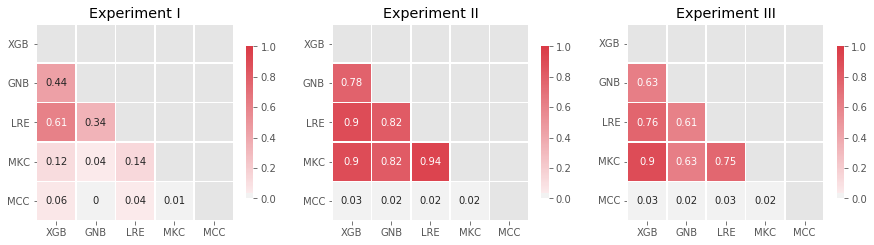

In [81]:
cols = [i for i in preds.columns if 'performance' in i]
temp = preds[cols] == 'y'
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols
corr1 = temp.corr()
corr1 = round(corr1, 2)

cols = [i for i in preds.columns if 'market' in i]
temp = preds[cols] == 'y'
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols
corr2 = temp.corr()
corr2 = round(corr2, 2)

cols = [i for i in preds.columns if 'total' in i]
temp = preds[cols] == 'y'
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols
corr3 = temp.corr()
corr3 = round(corr3, 2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axs = plt.subplots(ncols=3, figsize=(15,4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.yticks(rotation=0, fontsize="10", va="center")

sns.heatmap(corr1,cmap=cmap, mask=mask, vmax=1, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .7}, ax=axs[0]).set_title('Experiment I')

sns.heatmap(corr2, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .7}, ax=axs[1]).set_title('Experiment II')

sns.heatmap(corr3, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .7}, ax=axs[2]).set_title('Experiment III')

axs[0].tick_params(rotation=0)
axs[1].tick_params(rotation=0)
axs[2].tick_params(rotation=0)

plt.savefig('kappa.svg', bbox_inches='tight')
plt.show()



## Evolution of the performance of the classifiers in the beginning of the championship.

In [11]:
accs = pd.DataFrame()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:
        acc = list()
            
        filename = 'test.csv'
        pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)
        
        data = data[data['m.odds.s.bts.y.t.avg'].notna()]
        data = data[data['m.odds.s.bts.n.t.avg'].notna()]
    
        for r in range(1,11):
            temp = data[data['m.rg'] >= r]
            score = round(accuracy_score(temp[RESULT], temp['pred']),3)
            acc.append(score)
            

        col = '_'.join([c,e[0]])
        accs[col] = acc

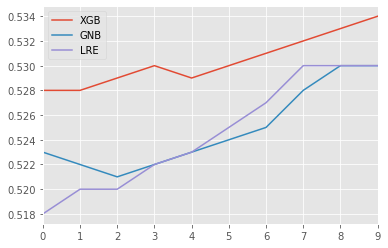

In [94]:
cols = [i for i in preds.columns if 'performance' in i]
temp = accs[cols]
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols

temp[['XGB', 'GNB', 'LRE']].plot()
plt.savefig('round.svg', bbox_inches='tight')

plt.show()

# Profit/Loss

## Using AVG Odds

In [14]:
cols = [i for i in pl.columns if 'AVG' in i]
cols_exp1 = [i for i in cols if 'performance' in i]
cols_exp2 = [i for i in cols if 'market' in i]
cols_exp3 = [i for i in cols if 'total' in i]

display(pl[cols_exp1])
display(pl[cols_exp2])
display(pl[cols_exp3])

,performance_PR_AVG,performance_PR_AVG_ROI,performance_EV_AVG,performance_EV_AVG_ROI,performance_KC_AVG,performance_KC_AVG_ROI
XGBClassifier,-405.9562,-6.348025,-338.5237,-10.474124,-23.285815,-11.914154
GaussianNB,-354.1313,-5.537628,-345.6193,-7.293085,-34.905578,-4.896558
LogisticRegression,-531.5726,-8.312316,-379.6031,-11.877444,-25.481547,-12.469838
mkc,-372.9806,-5.834203,0.0000,NaN,0.000000,NaN
mcc,-374.9833,-5.863695,-373.9833,-5.849887,-373.983300,-6.355918


,market_PR_AVG,market_PR_AVG_ROI,market_EV_AVG,market_EV_AVG_ROI,market_KC_AVG,market_KC_AVG_ROI
XGBClassifier,-387.9783,-6.068799,-52.9619,-13.476310,-1.051197,-10.106432
GaussianNB,-360.9834,-5.646542,-360.0187,-6.125892,-155.700271,-6.443011
LogisticRegression,-362.7466,-5.674122,1.4478,14.478000,-0.050190,-22.194099
mkc,-372.9806,-5.834203,0.0000,NaN,0.000000,NaN
mcc,-373.9833,-5.849887,-373.9833,-5.849887,-373.983300,-6.355918


,total_PR_AVG,total_PR_AVG_ROI,total_EV_AVG,total_EV_AVG_ROI,total_KC_AVG,total_KC_AVG_ROI
XGBClassifier,-375.1700,-5.868450,-63.3250,-18.249280,-1.159884,-16.435109
GaussianNB,-358.4357,-5.606690,-335.1299,-5.580848,-175.432535,-5.900259
LogisticRegression,-332.6777,-5.203781,-93.0181,-7.004375,-4.533831,-8.438322
mkc,-372.9806,-5.834203,0.0000,NaN,0.000000,NaN
mcc,-373.9833,-5.849887,-373.9833,-5.849887,-373.983300,-6.355918


## Using MAX Odds

In [15]:
cols = [i for i in pl.columns if 'MAX' in i]
cols_exp1 = [i for i in cols if 'performance' in i]
cols_exp2 = [i for i in cols if 'market' in i]
cols_exp3 = [i for i in cols if 'total' in i]

display(pl[cols_exp1])
display(pl[cols_exp2])
display(pl[cols_exp3])

,performance_PR_MAX,performance_PR_MAX_ROI,performance_EV_MAX,performance_EV_MAX_ROI,performance_KC_MAX,performance_KC_MAX_ROI
XGBClassifier,-82.91,-1.296482,-175.97,-3.053974,-17.189479,-3.629707
GaussianNB,-25.31,-0.395778,-79.15,-1.300099,5.874393,0.572213
LogisticRegression,-215.29,-3.366536,-228.59,-3.961012,-22.118776,-4.592394
mkc,-44.08,-0.689504,55.46,1.680606,0.580552,1.021683
mcc,-51.12,-0.799375,-50.12,-0.783982,-50.120000,-0.807361


,market_PR_MAX,market_PR_MAX_ROI,market_EV_MAX,market_EV_MAX_ROI,market_KC_MAX,market_KC_MAX_ROI
XGBClassifier,-56.02,-0.876271,-67.84,-1.467445,-0.425946,-0.305068
GaussianNB,-28.61,-0.447521,-31.39,-0.498808,-5.057724,-0.183570
LogisticRegression,-34.47,-0.539183,-11.81,-0.374326,0.421333,0.814806
mkc,-44.08,-0.689504,55.46,1.680606,0.580552,1.021683
mcc,-50.12,-0.783982,-50.12,-0.783982,-50.120000,-0.807361


,total_PR_MAX,total_PR_MAX_ROI,total_EV_MAX,total_EV_MAX_ROI,total_KC_MAX,total_KC_MAX_ROI
XGBClassifier,-42.20,-0.660097,-100.41,-2.129135,-0.674537,-0.481100
GaussianNB,-26.16,-0.409198,-20.12,-0.319011,8.398972,0.253711
LogisticRegression,-0.31,-0.004849,-75.07,-1.435922,-0.910284,-0.370754
mkc,-44.08,-0.689504,55.46,1.680606,0.580552,1.021683
mcc,-50.12,-0.783982,-50.12,-0.783982,-50.120000,-0.807361


## Analysing Odds Levels

In [95]:
def get_matrix_pl(e, c, col):
    

    filename = 'test.csv'
        
    pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
        
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            profit.loc[i/100, j/100] = temp[col].sum()

    return profit


def get_matrix_roi(e, c, col, bem=False):
    
    filename = 'test.csv'
        
    pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
        
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            
            nmatches = len(temp)
            if nmatches > 100:
                if bem:
                    profit.loc[i/100, j/100] = temp[col].sum()/nmatches*100
                else:
                    profit.loc[i/100, j/100] = temp[col].sum()/temp[col].abs().sum()
            else:
                profit.loc[i/100, j/100] = 0

    return profit

#### Processing Profitability with AVG Odds (Ranges)

In [17]:
mats_pr_avg = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_PR_PL_AVG)
        col = "_".join([c,e[0]])
        mats_pr_avg[col] = mat

In [18]:
mats_ev_avg = dict()
for e in EXPERIMENTS:        
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_EV_PL_AVG)
        col = "_".join([c,e[0]])
        mats_ev_avg[col] = mat

In [19]:
mats_kc_avg = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_KC_PL_AVG)
        col = "_".join([c,e[0]])
        mats_kc_avg[col] = mat

#### Processing Profitability with MAX Odds (Ranges)

In [20]:
mats_pr_max = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_PR_PL_MAX)
        col = "_".join([c,e[0]])
        mats_pr_max[col] = mat

In [21]:
mats_ev_max = dict()
for e in EXPERIMENTS:        
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_EV_PL_MAX)
        col = "_".join([c,e[0]])
        mats_ev_max[col] = mat

In [22]:
mats_kc_max = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_KC_PL_MAX)
        col = "_".join([c,e[0]])
        mats_kc_max[col] = mat

#### Processing ROI with AVG Odds (Ranges)

In [24]:
mats_pr_avg_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_PR_PL_AVG, True)
        col = "_".join([c,e[0]])
        mats_pr_avg_roi[col] = mat

In [25]:
mats_ev_avg_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_EV_PL_AVG)
        col = "_".join([c,e[0]])
        mats_ev_avg_roi[col] = mat

/home/igorcosta/anaconda3/envs/football/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


In [26]:
mats_kc_avg_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_KC_PL_AVG)
        col = "_".join([c,e[0]])
        mats_kc_avg_roi[col] = mat

/home/igorcosta/anaconda3/envs/football/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


#### Processing ROI with MAX Odds (Ranges)

In [27]:
mats_pr_max_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_PR_PL_MAX, True)
        col = "_".join([c,e[0]])
        mats_pr_max_roi[col] = mat

In [28]:
mats_ev_max_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_EV_PL_MAX)
        col = "_".join([c,e[0]])
        mats_ev_max_roi[col] = mat

In [29]:
mats_kc_max_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_KC_PL_MAX)
        col = "_".join([c,e[0]])
        mats_kc_max_roi[col] = mat

## Profitability per range

In [30]:
from mpl_toolkits.axes_grid1 import AxesGrid
def plot_heatmaps(mats):
    fig = plt.figure(figsize=(15,10))
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(3, 5),
                    axes_pad=0.3,
                    cbar_location="right",
                    cbar_mode="single",
                    )

    for ax, m in zip(grid, mats):

        label = m.split('_')[0]
        hm = ax.imshow(mats[m])
        ax.set_title(label)
        ax.set_yticks([1,10,20,30,40])
        ax.set_xticks([1,10,20,30,40])
        ax.set_yticklabels([.3,.4,.5,.6,.7,.8])
        ax.set_xticklabels([.3,.4,.5,.6,.7,.8])

    cbar = grid.cbar_axes[0].colorbar(hm, ticks=np.arange(-200,200,10))
    plt.show()
    
    
def best_results(mats):
    
    res = list()
    for m in mats:
        df_temp = mats[m]
        mxv_rows = df_temp.max(axis=1)
        mxv_cols = df_temp.max(axis=0)

        idx_row = mxv_rows.idxmax()
        idx_col = mxv_cols.idxmax()
        val = mxv_rows.max()
        res.append([m, idx_row, idx_col, val])
        
    return pd.DataFrame(res)
        

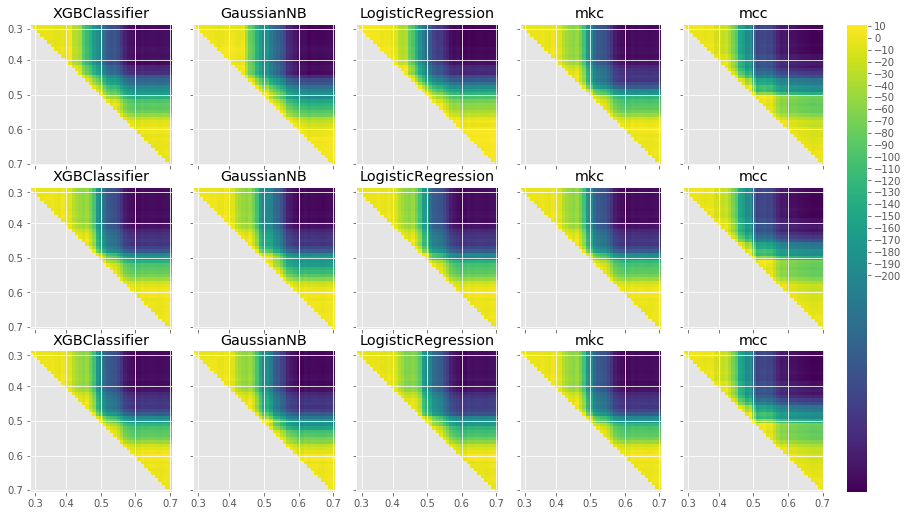

In [31]:
mats = mats_pr_avg
plot_heatmaps(mats)

In [32]:
mats = mats_pr_avg
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.40,0.41,14.2953
1,GaussianNB_performance,0.63,0.69,7.3098
2,LogisticRegression_performance,0.61,0.69,8.1645
3,mkc_performance,0.60,0.69,11.3411
4,mcc_performance,0.48,0.49,11.6455
5,XGBClassifier_market,0.60,0.69,11.3411
6,GaussianNB_market,0.45,0.46,9.0513
7,LogisticRegression_market,0.60,0.69,11.3411
8,mkc_market,0.60,0.69,11.3411
9,mcc_market,0.48,0.49,11.6455


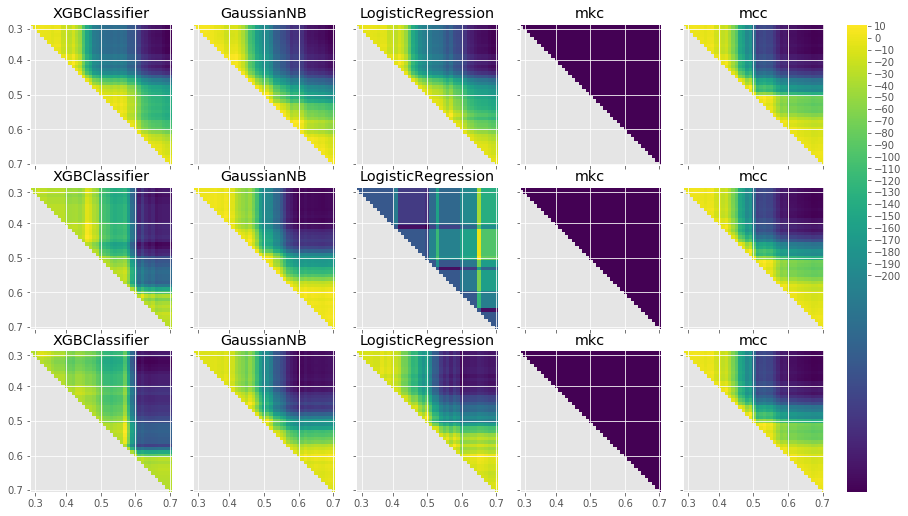

In [33]:
mats = mats_ev_avg
plot_heatmaps(mats)

In [34]:
mats = mats_ev_avg
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.41,0.42,11.9536
1,GaussianNB_performance,0.39,0.42,5.8876
2,LogisticRegression_performance,0.56,0.57,15.6925
3,mkc_performance,0.30,0.30,0.0000
4,mcc_performance,0.48,0.49,11.6455
5,XGBClassifier_market,0.44,0.46,5.9694
6,GaussianNB_market,0.45,0.46,9.0513
7,LogisticRegression_market,0.50,0.65,3.0241
8,mkc_market,0.30,0.30,0.0000
9,mcc_market,0.48,0.49,11.6455


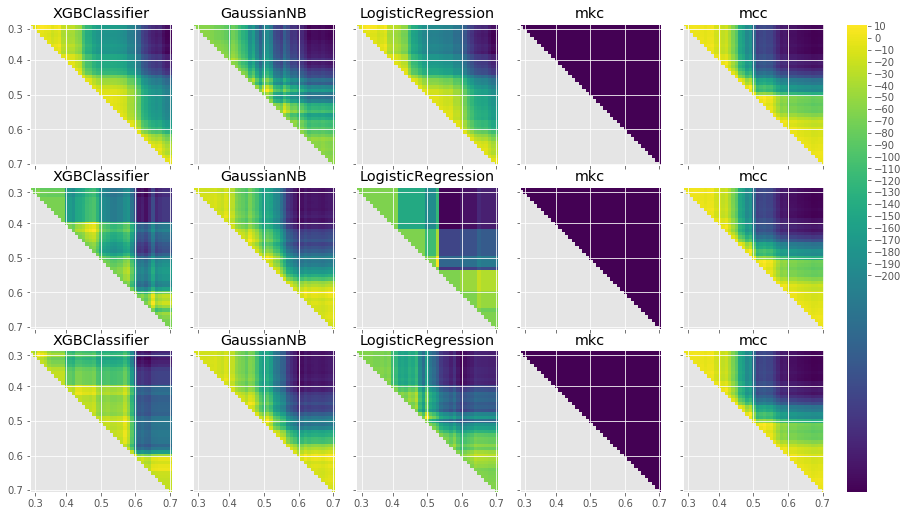

In [35]:
mats = mats_kc_avg
plot_heatmaps(mats)

In [36]:
mats = mats_kc_avg
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.31,0.33,1.019311
1,GaussianNB_performance,0.49,0.51,7.135804
2,LogisticRegression_performance,0.31,0.33,1.208959
3,mkc_performance,0.30,0.30,0.000000
4,mcc_performance,0.48,0.49,11.645500
5,XGBClassifier_market,0.42,0.48,0.299057
6,GaussianNB_market,0.45,0.46,11.314718
7,LogisticRegression_market,0.50,0.53,0.013575
8,mkc_market,0.30,0.30,0.000000
9,mcc_market,0.48,0.49,11.645500


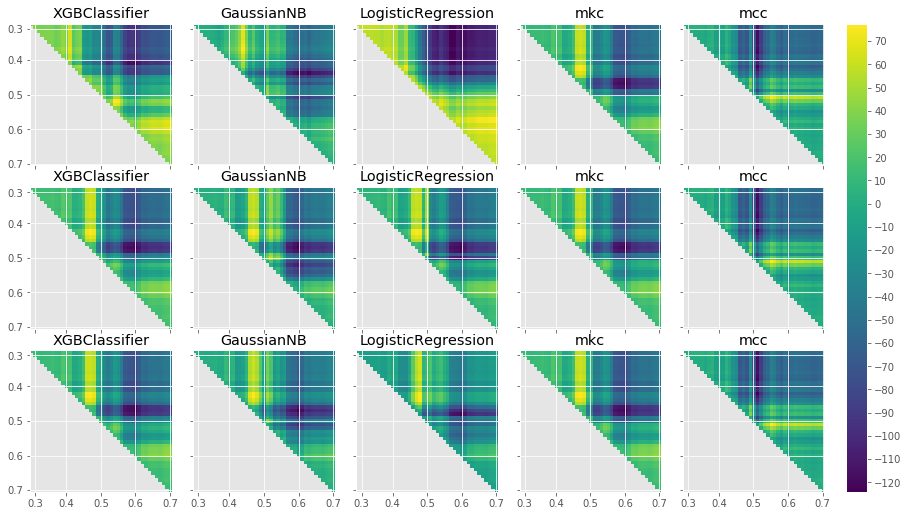

In [37]:
mats = mats_pr_max
plot_heatmaps(mats)

In [38]:
mats = mats_pr_max
best_results(mats)

,0,1,2,3
0,XGBClassifier_performance,0.52,0.54,31.38
1,GaussianNB_performance,0.37,0.44,47.12
2,LogisticRegression_performance,0.58,0.69,28.84
3,mkc_performance,0.42,0.47,52.23
4,mcc_performance,0.51,0.55,77.40
5,XGBClassifier_market,0.42,0.47,53.45
6,GaussianNB_market,0.42,0.47,52.23
7,LogisticRegression_market,0.42,0.47,52.23
8,mkc_market,0.42,0.47,52.23
9,mcc_market,0.51,0.55,77.40


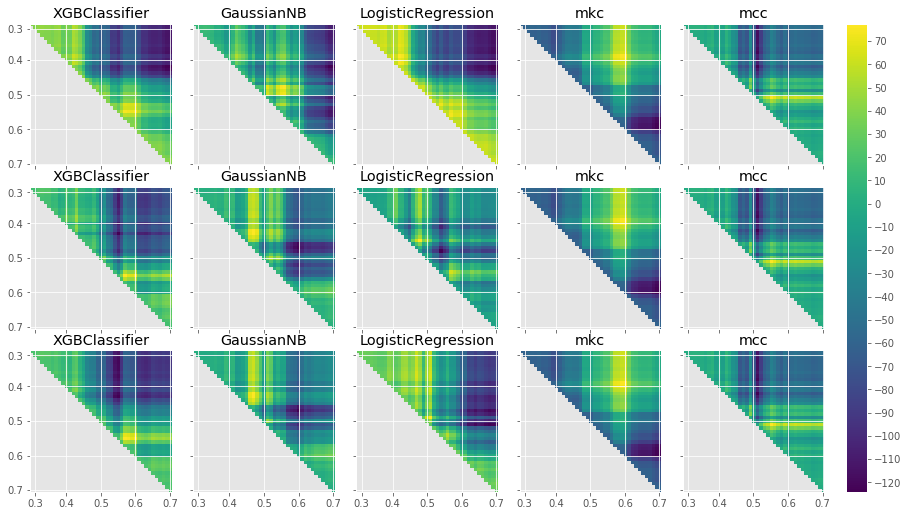

In [39]:
mats = mats_ev_max
plot_heatmaps(mats)

In [40]:
mats = mats_ev_max
best_results(mats)

,0,1,2,3
0,XGBClassifier_performance,0.55,0.60,42.01
1,GaussianNB_performance,0.48,0.56,40.69
2,LogisticRegression_performance,0.39,0.42,21.99
3,mkc_performance,0.39,0.60,142.75
4,mcc_performance,0.51,0.55,77.40
5,XGBClassifier_market,0.55,0.57,42.84
6,GaussianNB_market,0.42,0.47,52.23
7,LogisticRegression_market,0.45,0.48,44.59
8,mkc_market,0.39,0.60,142.75
9,mcc_market,0.51,0.55,77.40


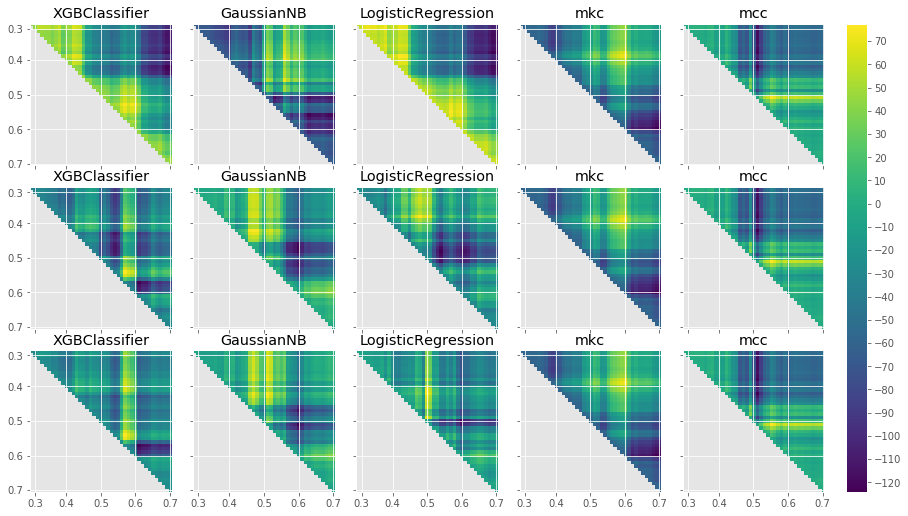

In [41]:
mats = mats_kc_max
plot_heatmaps(mats)

In [42]:
mats = mats_kc_max
best_results(mats)

,0,1,2,3
0,XGBClassifier_performance,0.53,0.57,3.446585
1,GaussianNB_performance,0.40,0.56,19.477306
2,LogisticRegression_performance,0.39,0.42,2.213945
3,mkc_performance,0.39,0.60,2.458890
4,mcc_performance,0.51,0.55,77.400000
5,XGBClassifier_market,0.54,0.57,2.514871
6,GaussianNB_market,0.42,0.47,37.056193
7,LogisticRegression_market,0.38,0.48,1.280594
8,mkc_market,0.39,0.60,2.458890
9,mcc_market,0.51,0.55,77.400000


## ROI per range

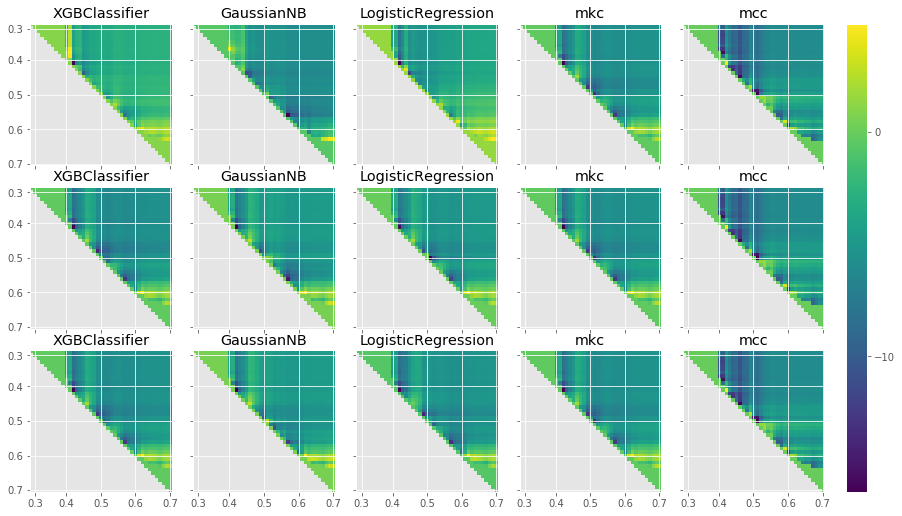

In [99]:
mats = mats_pr_avg_roi
plot_heatmaps(mats)

In [44]:
mats = mats_pr_avg_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.38,0.41,6.444405
1,GaussianNB_performance,0.63,0.69,6.041157
2,LogisticRegression_performance,0.63,0.69,5.314050
3,mkc_performance,0.60,0.62,5.923822
4,mcc_performance,0.41,0.42,4.821200
5,XGBClassifier_market,0.60,0.62,5.923822
6,GaussianNB_market,0.60,0.62,4.736545
7,LogisticRegression_market,0.60,0.62,5.923822
8,mkc_market,0.60,0.62,5.923822
9,mcc_market,0.41,0.42,4.821200


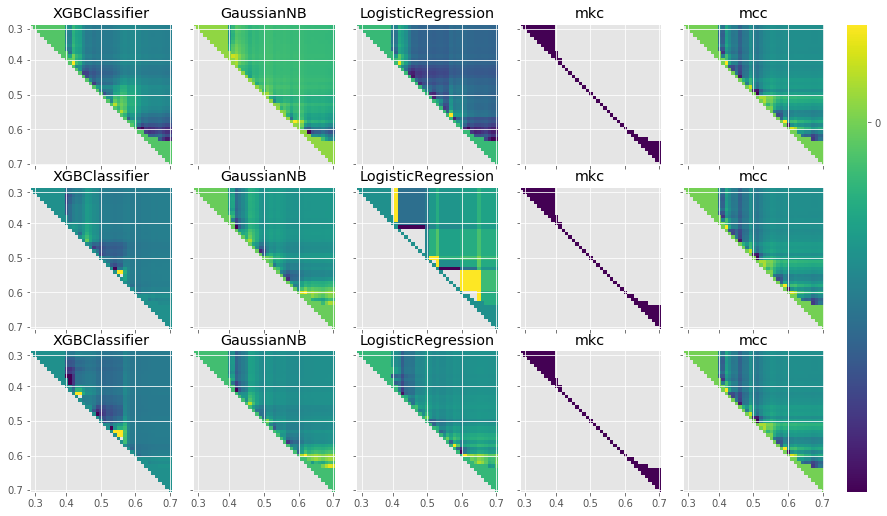

In [45]:
mats = mats_ev_avg_roi
plot_heatmaps(mats)

In [46]:
mats = mats_ev_avg_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.41,0.42,0.086649
1,GaussianNB_performance,0.58,0.59,0.070928
2,LogisticRegression_performance,0.56,0.57,0.103449
3,mkc_performance,0.30,0.30,0.000000
4,mcc_performance,0.58,0.59,0.045793
5,XGBClassifier_market,0.54,0.55,1.000000
6,GaussianNB_market,0.60,0.62,0.069035
7,LogisticRegression_market,0.30,0.41,1.000000
8,mkc_market,0.30,0.30,0.000000
9,mcc_market,0.58,0.59,0.045793


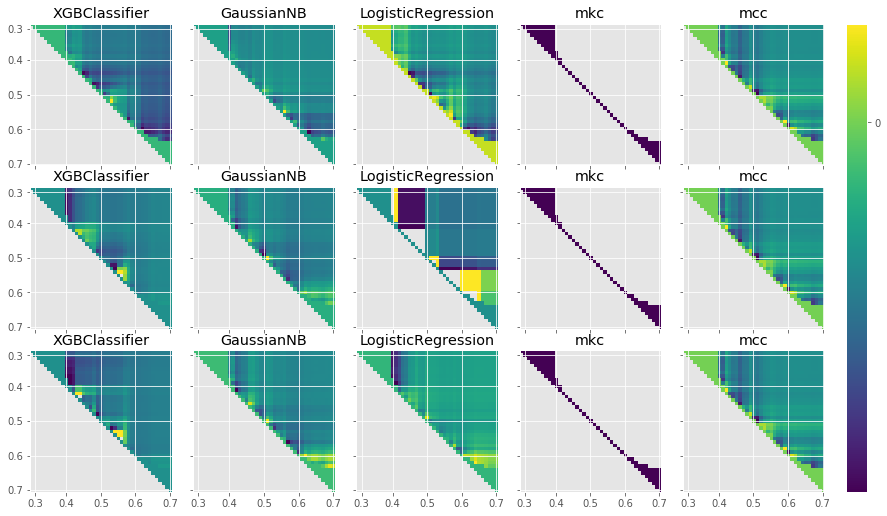

In [47]:
mats = mats_kc_avg_roi
plot_heatmaps(mats)

In [48]:
mats = mats_kc_avg_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.52,0.53,0.122638
1,GaussianNB_performance,0.55,0.56,0.240029
2,LogisticRegression_performance,0.56,0.57,0.025079
3,mkc_performance,0.30,0.30,0.000000
4,mcc_performance,0.58,0.59,0.045793
5,XGBClassifier_market,0.54,0.55,1.000000
6,GaussianNB_market,0.50,0.51,0.135474
7,LogisticRegression_market,0.30,0.41,1.000000
8,mkc_market,0.30,0.30,0.000000
9,mcc_market,0.58,0.59,0.045793


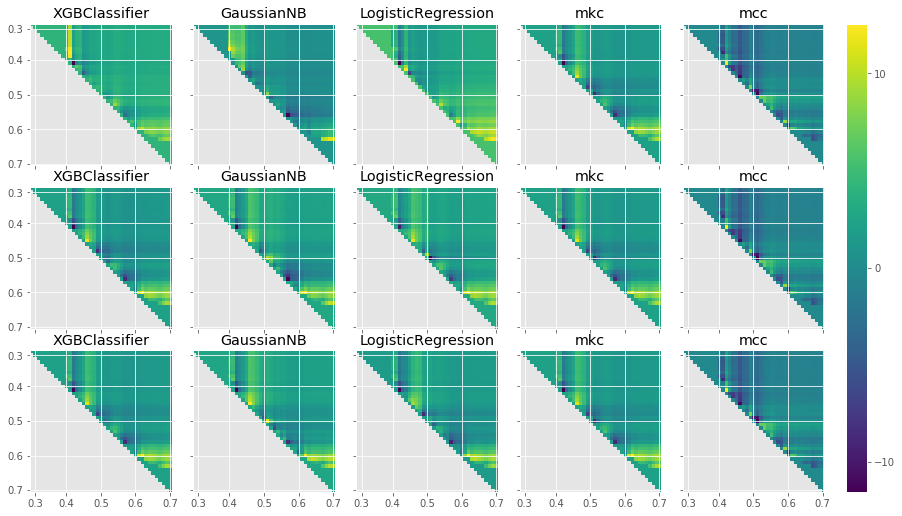

In [49]:
mats = mats_pr_max_roi
plot_heatmaps(mats)

In [50]:
mats = mats_pr_max_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.38,0.41,13.160714
1,GaussianNB_performance,0.37,0.40,11.625000
2,LogisticRegression_performance,0.43,0.44,9.818605
3,mkc_performance,0.60,0.62,9.947644
4,mcc_performance,0.41,0.42,12.552000
5,XGBClassifier_market,0.60,0.62,9.947644
6,GaussianNB_market,0.45,0.46,8.997290
7,LogisticRegression_market,0.60,0.62,9.947644
8,mkc_market,0.60,0.62,9.947644
9,mcc_market,0.41,0.42,12.552000


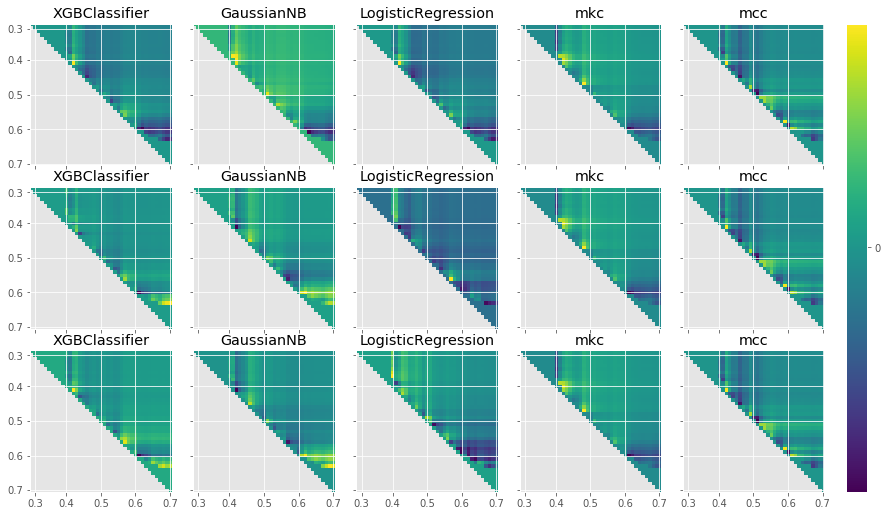

In [51]:
mats = mats_ev_max_roi
plot_heatmaps(mats)

In [52]:
mats = mats_ev_max_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.41,0.42,0.145071
1,GaussianNB_performance,0.40,0.42,0.102410
2,LogisticRegression_performance,0.41,0.42,0.129387
3,mkc_performance,0.47,0.48,0.277421
4,mcc_performance,0.41,0.42,0.107694
5,XGBClassifier_market,0.63,0.70,0.184294
6,GaussianNB_market,0.60,0.62,0.120657
7,LogisticRegression_market,0.56,0.57,0.322229
8,mkc_market,0.47,0.48,0.277421
9,mcc_market,0.41,0.42,0.107694


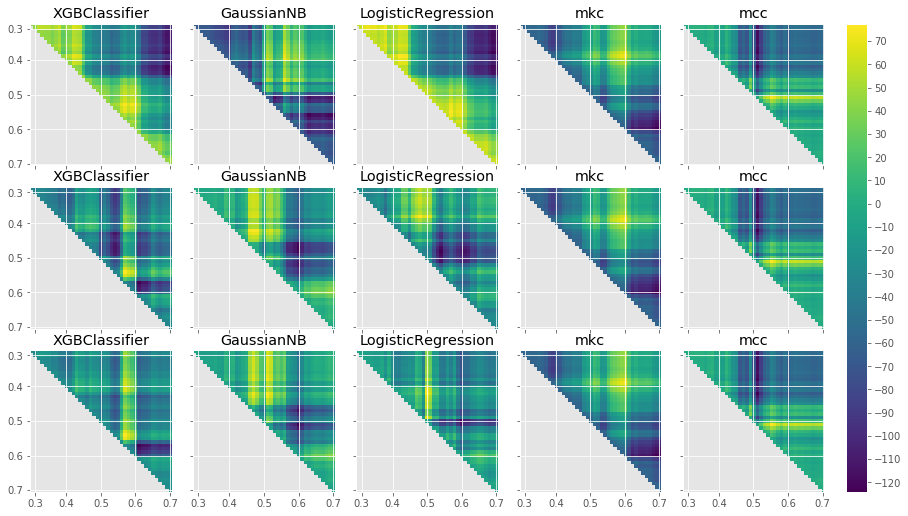

In [53]:
mats = mats_kc_max_roi
plot_heatmaps(mats)

In [54]:
mats = mats_kc_max_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.53,0.57,3.446585
1,GaussianNB_performance,0.40,0.56,19.477306
2,LogisticRegression_performance,0.39,0.42,2.213945
3,mkc_performance,0.39,0.60,2.458890
4,mcc_performance,0.51,0.55,77.400000
5,XGBClassifier_market,0.54,0.57,2.514871
6,GaussianNB_market,0.42,0.47,37.056193
7,LogisticRegression_market,0.38,0.48,1.280594
8,mkc_market,0.39,0.60,2.458890
9,mcc_market,0.51,0.55,77.400000


## Summary of Best Classifiers (Profitability per range)

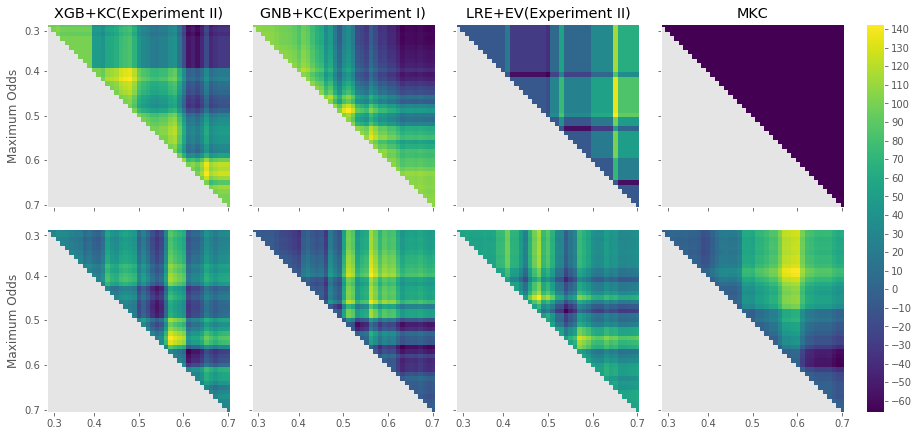

In [101]:
def plot_heatmaps_best(mats, titles):
    fig = plt.figure(figsize=(15,10))
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(2, 4),
                    axes_pad=0.3,
                    cbar_location="right",
                    cbar_mode="single",
                    )

    i = 0
    for ax, m, label in zip(grid, mats, titles):

        hm = ax.imshow(mats[m])
        ax.set_title(label)
        ax.set_yticks([1,10,20,30,40])
        ax.set_xticks([1,10,20,30,40])
        ax.set_yticklabels([.3,.4,.5,.6,.7,.8])
        ax.set_xticklabels([.3,.4,.5,.6,.7,.8])
        
        if i == 1:
            ax.set_ylabel('Average Odds')
            i = i+1
        else:
            ax.set_ylabel('Maximum Odds')
        
        ax.grid(False)
            

    cbar = grid.cbar_axes[0].colorbar(hm, ticks=np.arange(-200,200,10))
    plt.savefig('heats.svg', bbox_inches='tight')
    plt.show()

selected = ['XGBClassifier_market_KC',
            'GaussianNB_performance_KC',
            'LogisticRegression_market_EV',
            'mkc_performance_EV' ]

titles=['XGB+KC(Experiment II)','GNB+KC(Experiment I)','LRE+EV(Experiment II)','MKC', '', '', '', '', '']
mats_best = dict()
mats_best['XGBClassifier_market_KC_avg'] = mats_kc_avg['XGBClassifier_market']
mats_best['GaussianNB_performance_KC_avg'] = mats_kc_avg['GaussianNB_performance']
mats_best['LogisticRegression_market_EV_avg'] = mats_ev_avg['LogisticRegression_market']
mats_best['mkc_performance_EV_avg'] = mats_ev_avg['mkc_market']
mats_best['XGBClassifier_market_KC_max'] = mats_kc_max['XGBClassifier_market']
mats_best['GaussianNB_performance_KC_max'] = mats_kc_max['GaussianNB_performance']
mats_best['LogisticRegression_market_EV_max'] = mats_ev_max['LogisticRegression_market']
mats_best['mkc_performance_EV_max'] = mats_ev_max['mkc_market']

plot_heatmaps_best(mats_best, titles=titles)

In [56]:
display(best_results(mats_best))

,0,1,2,3
0,XGBClassifier_market_KC_avg,0.42,0.48,0.299057
1,GaussianNB_performance_KC_avg,0.49,0.51,7.135804
2,LogisticRegression_market_EV_avg,0.50,0.65,3.024100
3,mkc_performance_EV_avg,0.30,0.30,0.000000
4,XGBClassifier_market_KC_max,0.54,0.57,2.514871
5,GaussianNB_performance_KC_max,0.40,0.56,19.477306
6,LogisticRegression_market_EV_max,0.45,0.48,44.590000
7,mkc_performance_EV_max,0.39,0.60,142.750000


## Generating Latex Tables

In [102]:
def get_scores_table(df, features, caption, label):
    
    countries = CHAMPIONSHIPS
    abvs = get_abv_list(countries)

    tab = ''
    tab += '\\begin{table*}[ht!]' + '\n'
    tab += '\\small\\addtolength{\\tabcolsep}{-5pt}' + '\n'
    tab += '\\begin{tabularx}{\\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC|CC|CC}' + '\n'

    tab += '\\toprule' + '\n'
    tab += '\\multirow{2}{*}{CLF} & '
    
    for a in abvs:
        tab += '\\multicolumn{2}{c|}{' +  a + '}' + ' & '
    tab += ' \\multicolumn{2}{c}{Total}' + ' \\\ \n'
    tab += '\\cline{2-21}' + '\n'

    tab += ' & '
    
    for a in abvs:
        tab += 'ACC & BRS & '
    
    tab += 'ACC & BRS' + ' \\\ \n'
    tab += '\\midrule' + '\n'

    for i, c in enumerate(CLASSIFIERS):
        sc = df[(df['features'] == features) & (df['classifier'] == c)]
        if i % 2 == 1:
            tab += '\\rowcolor{Gray} \n'
        tab += classifier_abv[str(sc['classifier'].values[0])]
        for ch in CHAMPIONSHIPS + ['total']:
            scc = sc[sc['championship'] == ch]
            tab += ' & ' + str(round(scc['acc'].values[0],3)) + ' & ' + str(round(scc['bsl'].values[0],3))
        tab += '\n \\\ \n'

    tab += '\\bottomrule' + '\n'
    tab += '\multicolumn{10}{c}{CLF: Classifier | ACC: Accuracy | BRS: Brier Score}'
    tab += '\\end{tabularx}' + '\n'
    tab += '\\caption{' + caption + '}\n'
    tab += '\\label{' + label + '}\n'
    tab += '\\end{table*}' + '\n'
    
    return tab

print(get_scores_table(scores, 'performance', 
                       caption='Classifier performances in Experiment I',
                       label='tab:scores1'))
print(get_scores_table(scores, 'market', 
                       caption='Classifier performances in Experiment II',
                       label='tab:scores2'))
print(get_scores_table(scores, 'total', 
                       caption='Classifier performances in Experiment III',
                       label='tab:scores3'))

\begin{table*}[ht!]
\small\addtolength{\tabcolsep}{-5pt}
\begin{tabularx}{\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC|CC|CC}
\toprule
\multirow{2}{*}{CLF} & \multicolumn{2}{c|}{BR1} & \multicolumn{2}{c|}{BR2} & \multicolumn{2}{c|}{GB1} & \multicolumn{2}{c|}{FR1} & \multicolumn{2}{c|}{DE1} & \multicolumn{2}{c|}{IT1} & \multicolumn{2}{c|}{NL1} & \multicolumn{2}{c|}{PT1} & \multicolumn{2}{c|}{ES1} &  \multicolumn{2}{c}{Total} \\ 
\cline{2-21}
 & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS \\ 
\midrule
XGB & 0.528 & 0.25 & 0.503 & 0.25 & 0.509 & 0.25 & 0.511 & 0.25 & 0.551 & 0.247 & 0.532 & 0.25 & 0.587 & 0.245 & 0.508 & 0.25 & 0.537 & 0.249 & 0.528 & 0.249
 \\ 
\rowcolor{Gray} 
GNB & 0.526 & 0.255 & 0.501 & 0.258 & 0.516 & 0.26 & 0.499 & 0.257 & 0.554 & 0.251 & 0.532 & 0.261 & 0.547 & 0.255 & 0.516 & 0.258 & 0.522 & 0.259 & 0.523 & 0.257
 \\ 
LRE & 0.489 & 0.25 & 0.491 & 0.251 & 0.508 & 0.251 & 0.501 & 0.251 & 0.551 & 0.2

In [80]:
def get_pl_table(label, caption):
    
    def highlight(value):
        value = round(value, 2)
        if value > 0:
            return '\\poscell ' + str(value)
        else:
            if math.isnan(value):
                return '0'
            return str(value)
            
    exps = ['performance', 'market','total']
    preds = ['PR', 'EV', 'KC']
    
    countries = CHAMPIONSHIPS
    abvs = get_abv_list(countries)

    tab = ''
    tab += '\\begin{table*}[ht!]' + '\n'
    tab += '\\small\\addtolength{\\tabcolsep}{-8pt}' + '\n'
    tab += '\\begin{tabularx}{\\textwidth}{C|C|CC|CC|CC|CC|CC|CC}' + '\n'

    tab += '\\toprule' + '\n'
    tab += '\\multirow{3}{*}{CLF} & \multirow{3}{*}{BST} & '
    
    for i, a in enumerate(['Experiment I', 'Experiment II', 'Experiment III']):
        if i < 2:
            tab += '\\multicolumn{4}{c}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{4}{c|}{' +  a + '}'

    tab += '\\\ \\cline{3-14} & & '
    for i, a in enumerate(['AVG', 'MAX']*3):
        if i < 5:
            tab += '\\multicolumn{2}{c|}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{2}{c}{' +  a + '}'
        
    tab += '\\\ \\cline{3-14} & & '
    
    for i, a in enumerate(['AVG', 'MAX']*3):
        tab += 'PROF & ROI'
        if i < 5:
             tab+= ' & '

    tab += '\\\ \n\\midrule \n'

    for c in CLASSIFIERS:

        tab += '\\multirow{3}{*}{' + classifier_abv[c] + '}'
        sc = pl[pl.index == c]
        
        for p in preds:
            tab += ' & ' + p
            
            for e in exps: 
                tab += ' & '
                col_avg_v = '_'.join([e,p,'AVG'])
                col_max_v = '_'.join([e,p,'MAX'])
                
                col_avg_r = '_'.join([e,p,'AVG', 'ROI'])
                col_max_r = '_'.join([e,p,'MAX', 'ROI'])
                                
                if 'mkc' and 'avg' not in e[0]:
                    tab += highlight(sc[col_avg_v].values[0]) + ' & '   
                    tab += highlight(sc[col_avg_r].values[0]) + '\% & '
                    tab += highlight(sc[col_max_v].values[0]) + ' & '
                    tab += highlight(sc[col_max_r].values[0]) + '\% '
                else:
                    tab += 'N/A & '   
                    tab += 'N/A & '
                    tab += highlight(sc[col_max_v].values[0]) + ' & '
                    tab += highlight(sc[col_max_r].values[0]) + '\% '

                
            tab += '\\\ \n'
        tab += '\\hline \n'    
        
    tab += '\\bottomrule' + '\n'
    tab += '\\multicolumn{14}{c}{CLF:Classifier | BST: Betting Strategy | PROF: Profitability | AVG: Betting on the average odd | MAX: Betting on the maximum odd}' + '\n'
    tab += '\\end{tabularx}' + '\n'
    tab += '\\caption{' + caption + '}\n'
    tab += '\\label{' + label + '}\n'
    tab += '\\end{table*}' + '\n'
    
    return tab

print(get_pl_table(caption='Profitability and ROI of Classifiers', label='tab:profitability'))

\begin{table*}[ht!]
\small\addtolength{\tabcolsep}{-8pt}
\begin{tabularx}{\textwidth}{C|C|CC|CC|CC|CC|CC|CC}
\toprule
\multirow{3}{*}{CLF} & \multirow{3}{*}{BST} & \multicolumn{4}{c}{Experiment I} & \multicolumn{4}{c}{Experiment II} & \multicolumn{4}{c|}{Experiment III}\\ \cline{3-14} & & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c}{MAX}\\ \cline{3-14} & & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI\\ 
\midrule 
\multirow{3}{*}{XGB} & PR & -405.96 & -6.35\% & -82.91 & -1.3\%  & -387.98 & -6.07\% & -56.02 & -0.88\%  & -375.17 & -5.87\% & -42.2 & -0.66\% \\ 
 & EV & -338.52 & -10.47\% & -175.97 & -3.05\%  & -52.96 & -13.48\% & -67.84 & -1.47\%  & -63.32 & -18.25\% & -100.41 & -2.13\% \\ 
 & KC & -23.29 & -11.91\% & -17.19 & -3.63\%  & -1.05 & -10.11\% & -0.43 & -0.31\%  & -1.16 & -16.44\% & -0.67 & -0.48\% \\ 
\hline 
\multirow{3}{*}{GNB} & PR & -35

In [103]:
def get_pl_table(label, caption):
    
    def highlight(value):
        value = round(value, 2)
        if value > 0:
            return '\\poscell' + str(value)
        else:
            if math.isnan(value):
                return '0'
            return str(value)
            
    selected = ['XGBClassifier_market_KC',
                'GaussianNB_performance_KC',
                'LogisticRegression_market_EV',
                'mkc_performance_EV' ]
    
    
    countries = CHAMPIONSHIPS
    abvs = get_abv_list(countries)

    tab = ''
    tab += '\\begin{table*}[ht!]' + '\n'
    tab += '\\small\\addtolength{\\tabcolsep}{-8pt}' + '\n'
    tab += '\\begin{tabularx}{\\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC}' + '\n'

    tab += '\\toprule' + '\n'
    tab += '\\multirow{3}{*}{CH} & '
    
    for i, a in enumerate(['XGB+KC (Experiment II)', 'GNB+KC (Experiment I)', 'LRE+EV (Experiment II)', 'MKC+EV']):
        if i < 3:
            tab += '\\multicolumn{4}{c|}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{4}{c}{' +  a + '}' + ' \n '

    tab += '\\\ \\cline{2-17} & '
    for i, a in enumerate(['AVG', 'MAX']*4):
        if i < 7:
            tab += '\\multicolumn{2}{c|}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{2}{c}{' +  a + '}' + ' \n '

    tab += '\\\ \\cline{2-17} & '
    
    for i, a in enumerate(['AVG', 'MAX']*4):
        tab += 'PROF & ROI'
        if i < 7:
            tab+= ' & '

    tab += '\\\ \n\\midrule \n'

    for c in countries:
        
        tab += countries_abv[c]
        sc = pl_champ[pl_champ.index == c]

        for e in selected:

            tab += ' & '
            col_avg_v = '_'.join([e,'AVG'])
            col_max_v = '_'.join([e,'MAX'])

            col_avg_r = '_'.join([e,'AVG', 'ROI'])
            col_max_r = '_'.join([e,'MAX', 'ROI'])

            tab += highlight(sc[col_avg_v].values[0]) + ' & '   
            tab += highlight(sc[col_avg_r].values[0]) + '\% & '
            tab += highlight(sc[col_max_v].values[0]) + ' & '
            tab += highlight(sc[col_max_r].values[0]) + '\% '


        tab += '\\\ \\hline \n'    
        
    tab += '\\bottomrule' + '\n'
    tab += '\\multicolumn{17}{c}{CH:Championship | PROF: Profitability | AVG: Betting on the average odd | MAX: Betting on the maximum odd}' + '\n'
    tab += '\\end{tabularx}' + '\n'
    tab += '\\caption{' + caption + '}\n'
    tab += '\\label{' + label + '}\n'
    tab += '\\end{table*}' + '\n'
    
    return tab

print(get_pl_table(caption='Profitability and ROI of best classifiers per championship', label='tab:prof_by_champ'))

\begin{table*}[ht!]
\small\addtolength{\tabcolsep}{-8pt}
\begin{tabularx}{\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC}
\toprule
\multirow{3}{*}{CH} & \multicolumn{4}{c|}{XGB+KC (Experiment II)} & \multicolumn{4}{c|}{GNB+KC (Experiment I)} & \multicolumn{4}{c|}{LRE+EV (Experiment II)} & \multicolumn{4}{c}{MKC+EV} 
 \\ \cline{2-17} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c}{MAX} 
 \\ \cline{2-17} & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI\\ 
\midrule 
BR1 & -0.04 & -51.74\% & -0.43 & -5.32\%  & -3.76 & -5.06\% & -0.42 & -0.38\%  & 0.0 & 0\% & \poscell12.2 & \poscell3.92\%  & 0.0 & 0\% & -9.03 & -3.49\% \\ \hline 
BR2 & \poscell0.02 & \poscell10.39\% & \poscell1.04 & \poscell11.61\%  & -0.46 & -0.54\% & \poscell5.73 & \poscell4.65\%  & -0.15 & -7.71\% & \poscell9.71 & \p